In [61]:
from sympy import *
import pandas as pd
from dtumathtools import*
import uncertainties as unc
import uncertainties.umath as umath
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import os
init_printing()

# Actual results

In [62]:
TrimDataTest1Run1 = pd.read_csv("data/test1run1.csv")
TrimDataTest1Run2 = pd.read_csv("data/test1run2.csv")
TrimDataTest1Run3 = pd.read_csv("data/test1run3.csv")

TrimDataTest2Run1 = pd.read_csv("data/test2run1.csv")
TrimDataTest2Run2 = pd.read_csv("data/test2run2.csv")
TrimDataTest2Run3 = pd.read_csv("data/test2run3.csv")

TrimDataTest3Run1 = pd.read_csv("data/test3run1.csv")
TrimDataTest3Run2 = pd.read_csv("data/test3run2.csv")
TrimDataTest3Run3 = pd.read_csv("data/test3run3.csv")


In [63]:
import matplotlib.pyplot as plt

def plot_displacement_velocity_acceleration(datasets, labels=None, title="Motion Data Overview"):
    """
    Plots displacement, velocity, and acceleration vs time for multiple datasets
    in a single figure with 3 stacked subplots.

    Parameters:
        datasets (list): List of pandas DataFrames (each read from a CSV)
        labels (list): Optional list of labels for each dataset
        title (str): Title of the overall figure
    """
    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    for i, df in enumerate(datasets):
        label = labels[i] if labels else f"Run {i+1}"
        time = df[" time"]
        displacement = df[" cal[0]"]
        velocity = df[" cal[1]"]
        acceleration = df[" cal[2]"]

        axs[0].plot(time, displacement, label=label)
        axs[1].plot(time, velocity, label=label)
        axs[2].plot(time, acceleration, label=label)

    # Titles and axis labels
    axs[0].set_ylabel("Displacement (m)")
    axs[1].set_ylabel("Velocity (m/s)")
    axs[2].set_ylabel("Acceleration (m/s²)")
    axs[2].set_xlabel("Time (s)")

    # Legends and grids
    for ax in axs:
        ax.grid(True)
        ax.legend()

    # Overall figure title
    fig.suptitle(title)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

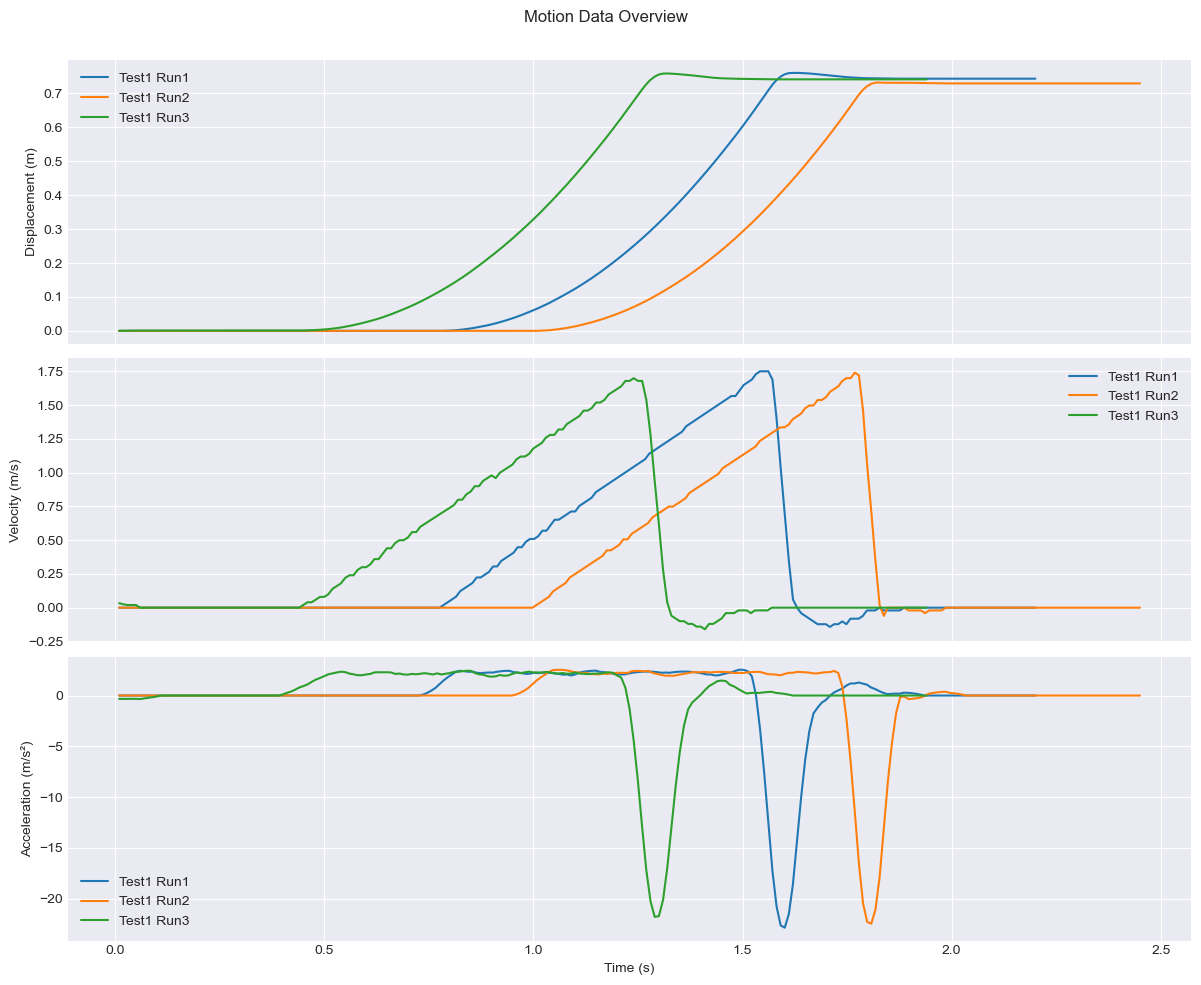

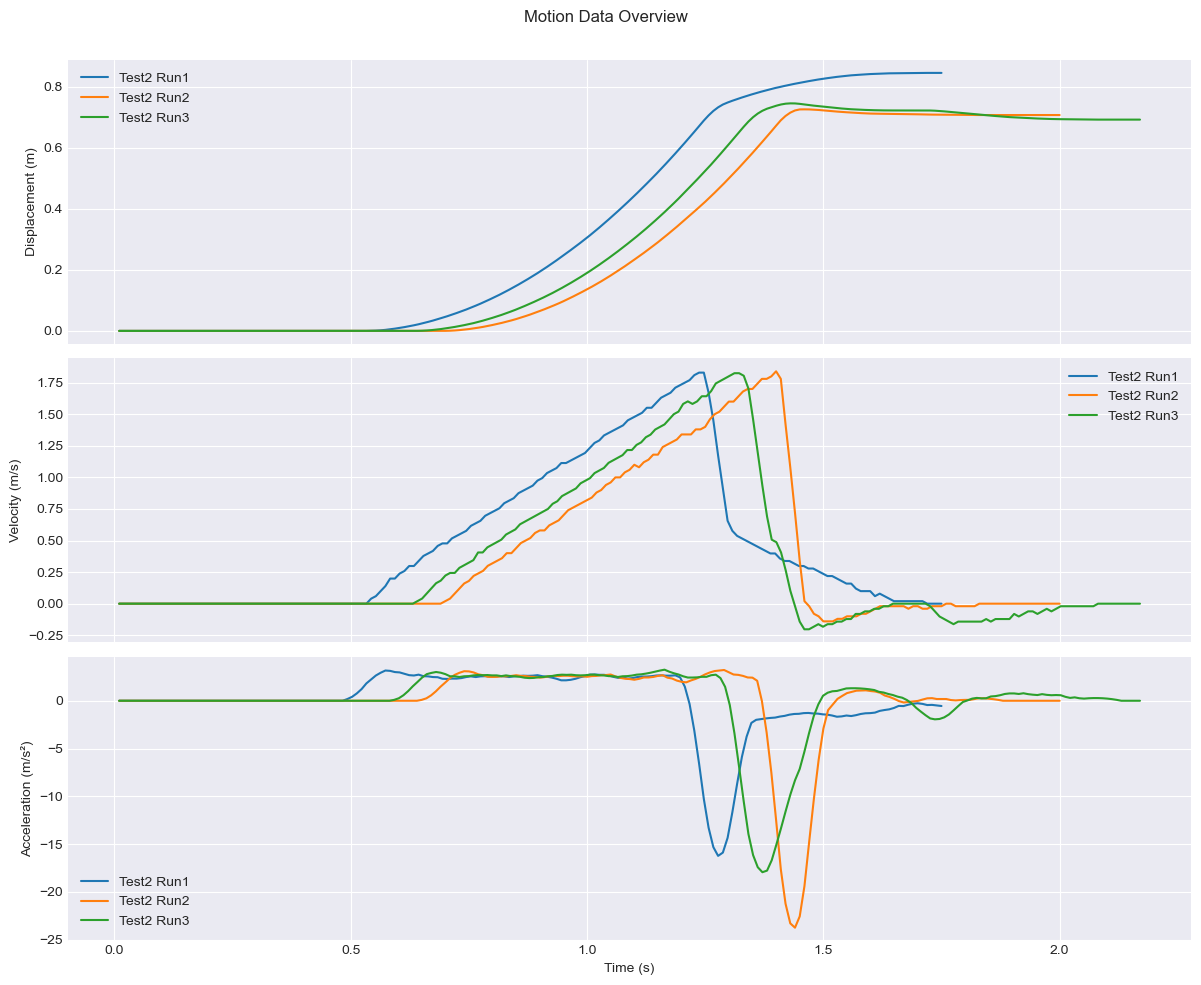

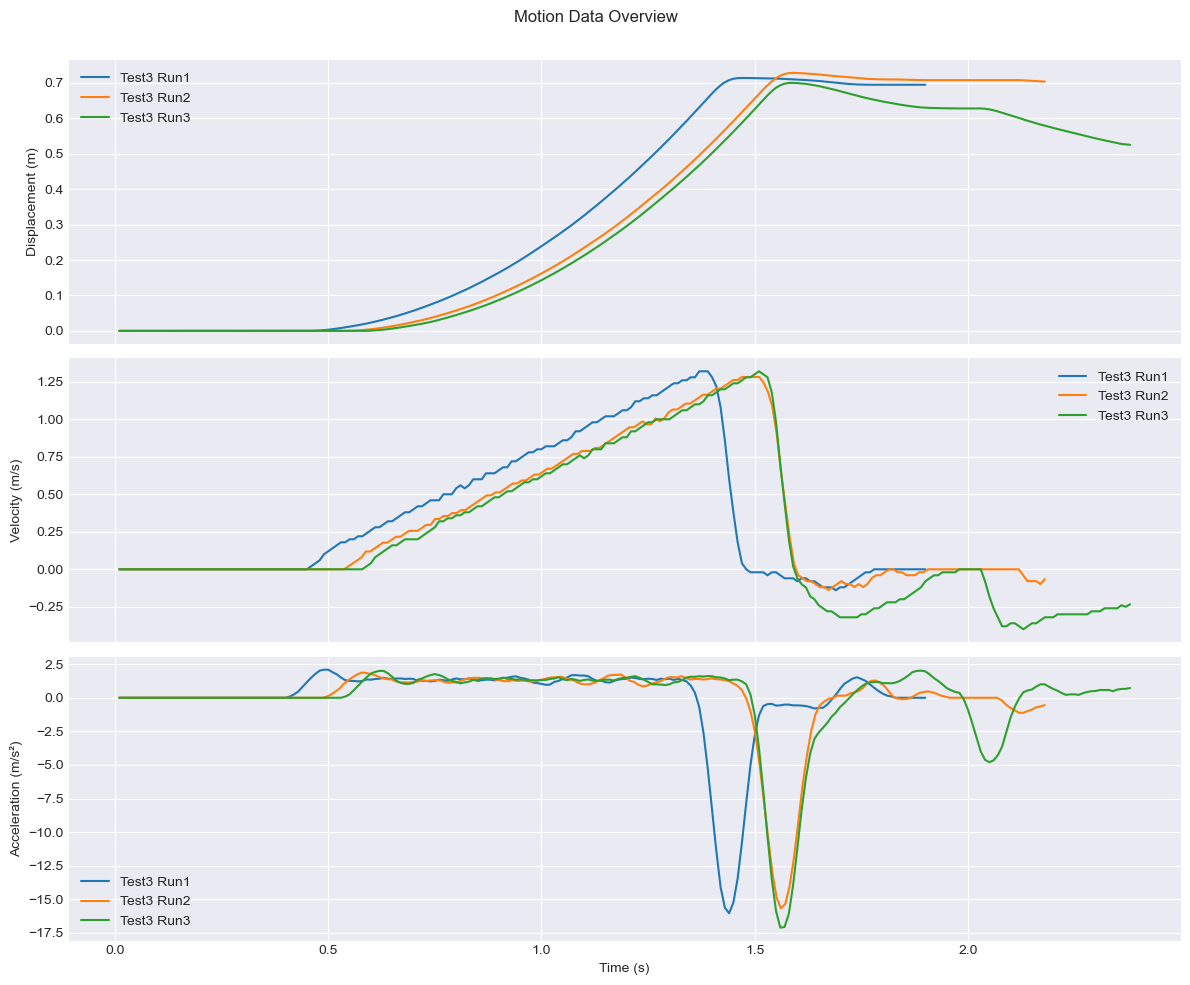

In [64]:
datasets_test1 = [TrimDataTest1Run1, TrimDataTest1Run2, TrimDataTest1Run3]
datasets_test2 = [TrimDataTest2Run1, TrimDataTest2Run2, TrimDataTest2Run3]
datasets_test3 = [TrimDataTest3Run1, TrimDataTest3Run2, TrimDataTest3Run3]

plot_displacement_velocity_acceleration(datasets_test1, labels=["Test1 Run1", "Test1 Run2", "Test1 Run3"])
plot_displacement_velocity_acceleration(datasets_test2, labels=["Test2 Run1", "Test2 Run2", "Test2 Run3"])
plot_displacement_velocity_acceleration(datasets_test3, labels=["Test3 Run1", "Test3 Run2", "Test3 Run3"])

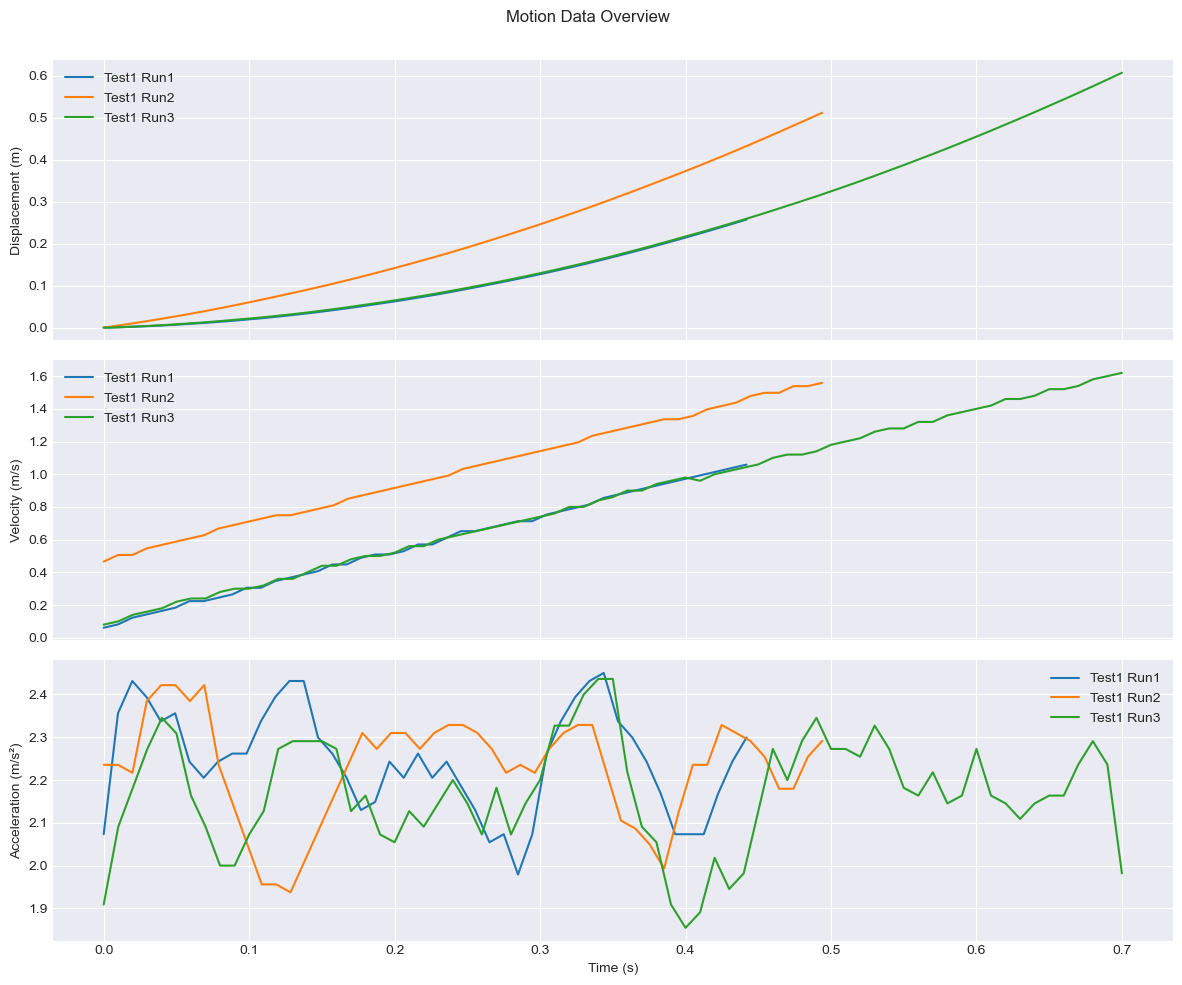

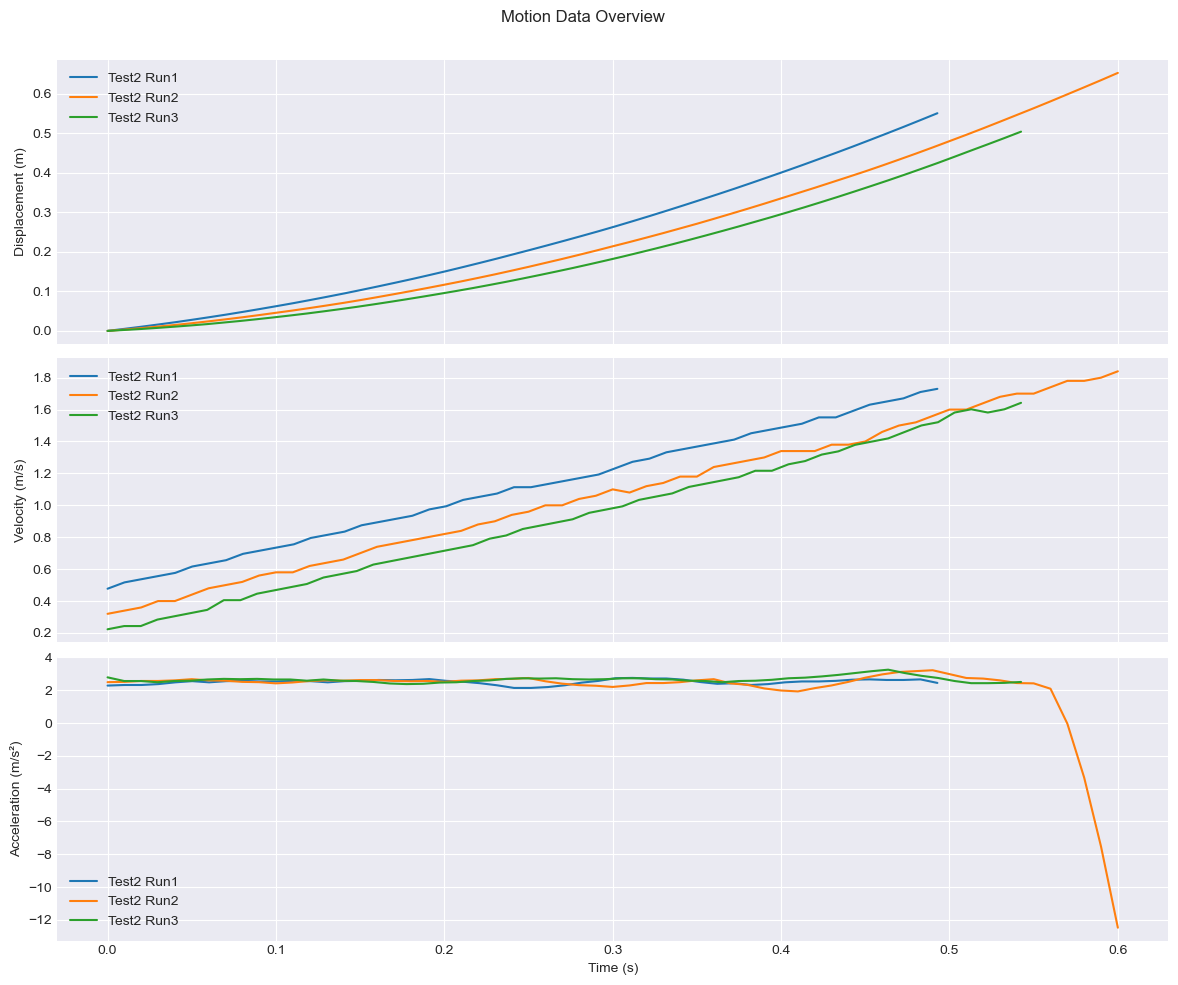

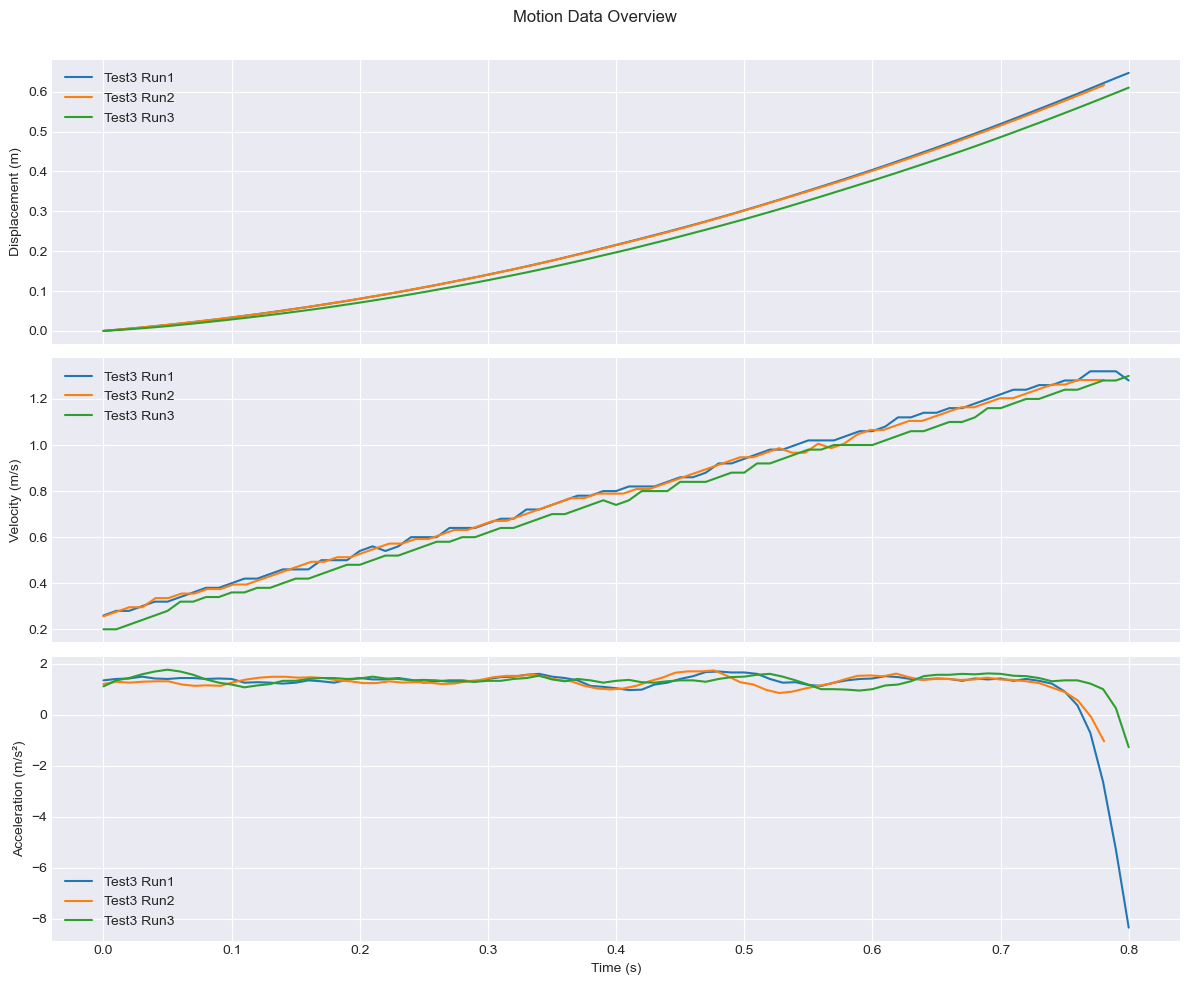

In [65]:
def trim_and_reset_time(data, tmin, tmax):
    """
    Filters the dataset to only include data within [tmin, tmax] and resets the time
    so that the earliest time becomes 0.

    Parameters:
        data (DataFrame): The full dataset with a ' time' column
        tmin (float): Minimum time to include
        tmax (float): Maximum time to include

    Returns:
        DataFrame: Cropped and time-shifted dataset
    """
    # Filter time range
    trimmed = data[(data[" time"] >= tmin) & (data[" time"] <= tmax)].copy()

    # Reset time so the smallest value is zero
    t0 = trimmed[" time"].min()
    trimmed[" time"] = trimmed[" time"] - t0

    p0 = trimmed[" cal[0]"].iloc[0]
    trimmed[" cal[0]"] = trimmed[" cal[0]"] - p0

    return trimmed


TrimDataTest1Run1 = trim_and_reset_time(TrimDataTest1Run1, 0.8, 1.25)
TrimDataTest1Run2 = trim_and_reset_time(TrimDataTest1Run2, 1.2, 1.7)
TrimDataTest1Run3 = trim_and_reset_time(TrimDataTest1Run3, 0.5, 1.2)

TrimDataTest2Run1 = trim_and_reset_time(TrimDataTest2Run1, 0.7, 1.2)
TrimDataTest2Run2 = trim_and_reset_time(TrimDataTest2Run2, 0.8, 1.4)
TrimDataTest2Run3 = trim_and_reset_time(TrimDataTest2Run3, 0.7, 1.25)

TrimDataTest3Run1 = trim_and_reset_time(TrimDataTest3Run1, 0.6, 1.4)
TrimDataTest3Run2 = trim_and_reset_time(TrimDataTest3Run2, 0.7, 1.5)
TrimDataTest3Run3 = trim_and_reset_time(TrimDataTest3Run3, 0.7, 1.5)

plot_displacement_velocity_acceleration([TrimDataTest1Run1, TrimDataTest1Run2, TrimDataTest1Run3], labels=["Test1 Run1", "Test1 Run2", "Test1 Run3"])
plot_displacement_velocity_acceleration([TrimDataTest2Run1, TrimDataTest2Run2, TrimDataTest2Run3], labels=["Test2 Run1", "Test2 Run2", "Test2 Run3"])
plot_displacement_velocity_acceleration([TrimDataTest3Run1, TrimDataTest3Run2, TrimDataTest3Run3], labels=["Test3 Run1", "Test3 Run2", "Test3 Run3"])


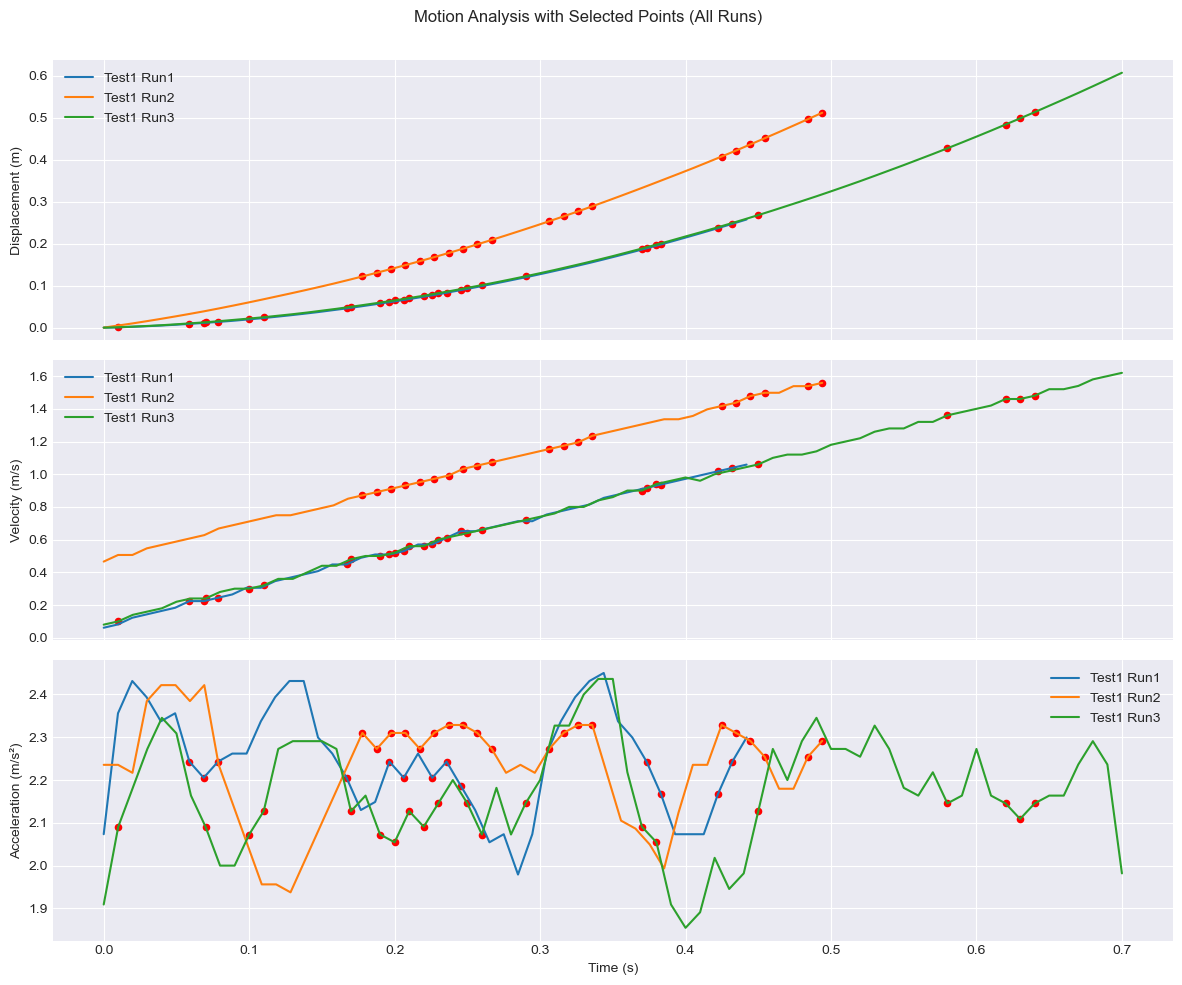

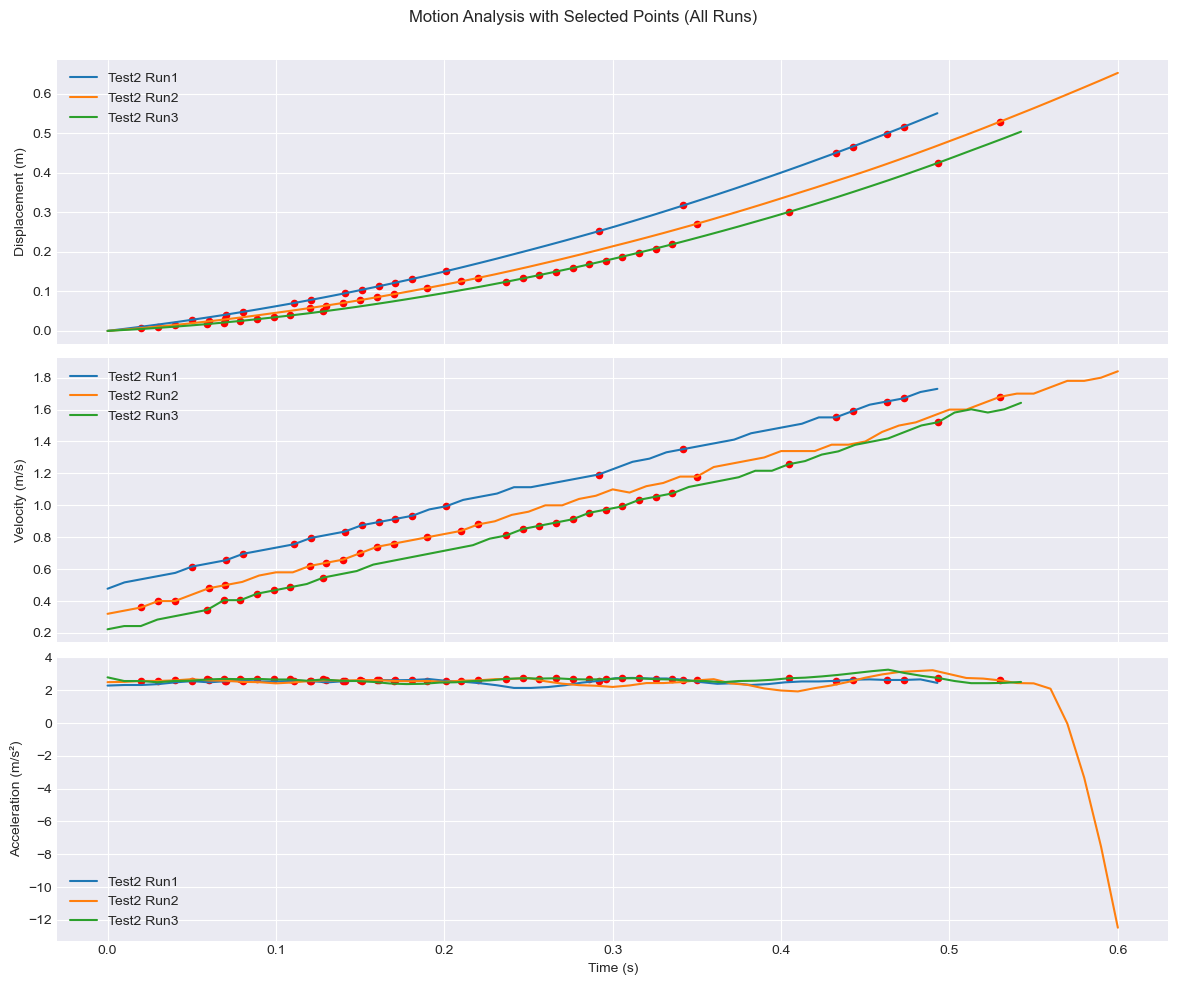

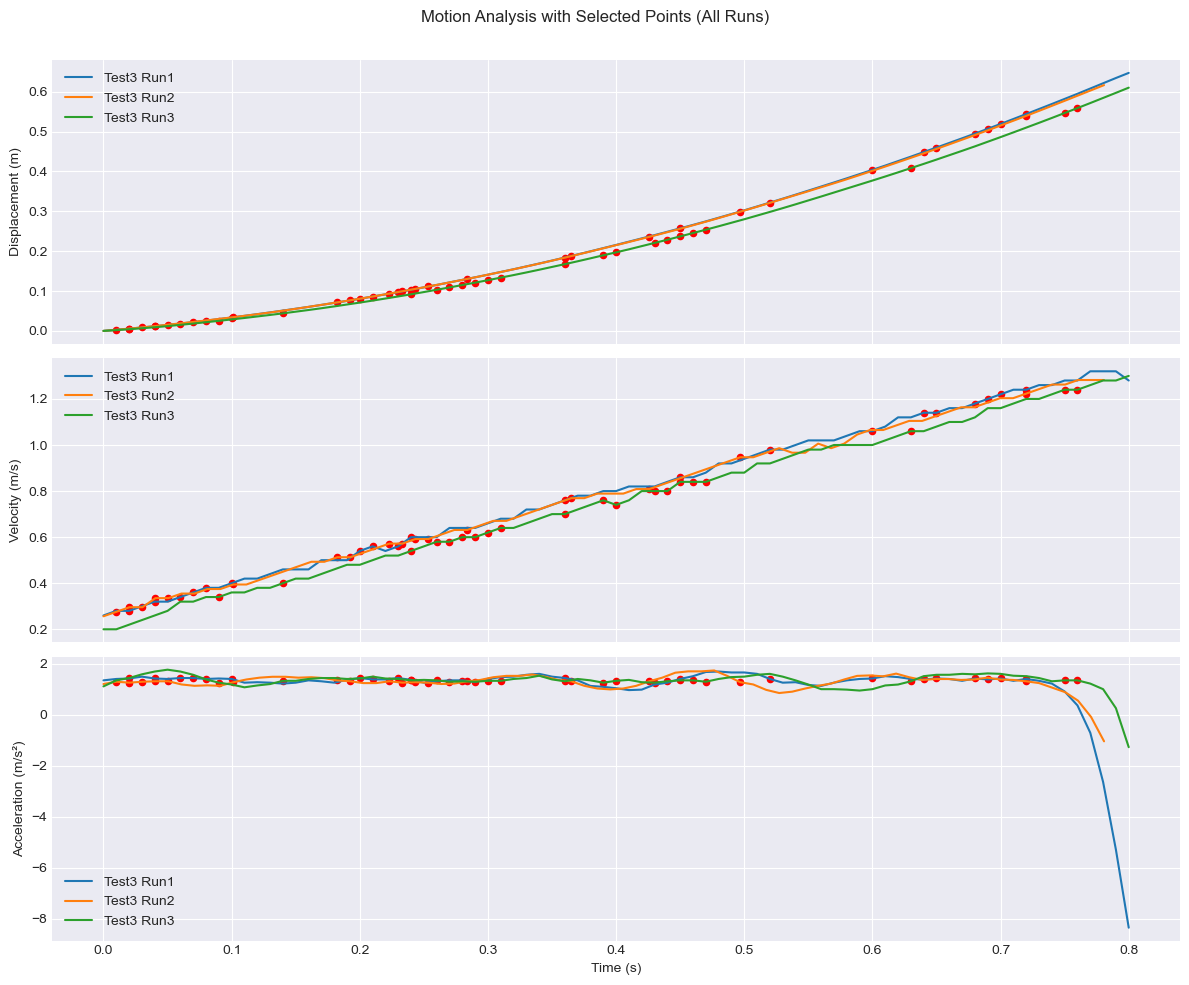

In [66]:
def chose_datapoints_with_nonzero_acceleration(data, amount, random_seed=None, round_to=1, min_abs_accel=0.5):
    """
    Choose datapoints where acceleration is non-zero and common.
    Filters out low accelerations, then selects around the median of the rest.

    Parameters:
        data (DataFrame): Full data from CSV
        amount (int): Number of points to select
        random_seed (int): Seed for reproducibility
        round_to (float): Rounding precision for grouping accelerations
        min_abs_accel (float): Minimum absolute acceleration to be considered "non-zero"

    Returns:
        DataFrame: Sample of datapoints with consistent, non-zero acceleration
    """
    # Filter out nearly-zero accelerations
    acc = data[" cal[2]"]
    non_zero_mask = acc.abs() >= min_abs_accel
    filtered_data = data[non_zero_mask].copy()

    if filtered_data.empty:
        raise ValueError("No data points found with significant acceleration.")

    # Round acceleration to group similar values
    filtered_data["rounded_acc"] = filtered_data[" cal[2]"].round(round_to)

    # Find the most frequent non-zero rounded acceleration
    most_common_acc = filtered_data["rounded_acc"].value_counts().idxmax()

    # Select only those with that rounded acceleration
    candidates = filtered_data[filtered_data["rounded_acc"] == most_common_acc]

    # Sample the requested amount
    selected = candidates.sample(min(amount, len(candidates)), random_state=random_seed)
    return selected.drop(columns=["rounded_acc"])

sortedDataTest1Run1 = chose_datapoints_with_nonzero_acceleration(TrimDataTest1Run1, 20, random_seed=0)
sortedDataTest1Run2 = chose_datapoints_with_nonzero_acceleration(TrimDataTest1Run2, 20, random_seed=0)
sortedDataTest1Run3 = chose_datapoints_with_nonzero_acceleration(TrimDataTest1Run3, 20, random_seed=0)

sortedDataTest2Run1 = chose_datapoints_with_nonzero_acceleration(TrimDataTest2Run1, 20, random_seed=0)
sortedDataTest2Run2 = chose_datapoints_with_nonzero_acceleration(TrimDataTest2Run2, 20, random_seed=0)
sortedDataTest2Run3 = chose_datapoints_with_nonzero_acceleration(TrimDataTest2Run3, 20, random_seed=0)

sortedDataTest3Run1 = chose_datapoints_with_nonzero_acceleration(TrimDataTest3Run1, 20, random_seed=0)
sortedDataTest3Run2 = chose_datapoints_with_nonzero_acceleration(TrimDataTest3Run2, 20, random_seed=0)
sortedDataTest3Run3 = chose_datapoints_with_nonzero_acceleration(TrimDataTest3Run3, 20, random_seed=0)

def plot_multiple_runs_with_selected_points(datasets, selected_datasets, labels=None, title="Motion Analysis with Selected Points (All Runs)"):
    """
    Plots displacement, velocity, and acceleration vs time for multiple runs.
    Highlights selected datapoints for each run in red.

    Parameters:
        datasets (list of DataFrame): Full cal data for each run
        selected_datasets (list of DataFrame): Selected points for each run
        labels (list of str): Optional list of labels for the runs
        title (str): Title for the entire figure
    """
    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    for i, (data, selected) in enumerate(zip(datasets, selected_datasets)):
        label = labels[i] if labels else f"Run {i+1}"

        # Full data
        time = data[" time"]
        disp = data[" cal[0]"]
        vel = data[" cal[1]"]
        acc = data[" cal[2]"]

        # Selected points
        time_sel = selected[" time"]
        disp_sel = selected[" cal[0]"]
        vel_sel = selected[" cal[1]"]
        acc_sel = selected[" cal[2]"]

        # Plot all 3 subplots
        axs[0].plot(time, disp, label=label)
        axs[0].scatter(time_sel, disp_sel, color="red", s=20)

        axs[1].plot(time, vel, label=label)
        axs[1].scatter(time_sel, vel_sel, color="red", s=20)

        axs[2].plot(time, acc, label=label)
        axs[2].scatter(time_sel, acc_sel, color="red", s=20)

    # Labeling axes
    axs[0].set_ylabel("Displacement (m)")
    axs[1].set_ylabel("Velocity (m/s)")
    axs[2].set_ylabel("Acceleration (m/s²)")
    axs[2].set_xlabel("Time (s)")

    # Add grids and legends
    for ax in axs:
        ax.grid(True)
        ax.legend()

    # Title and layout
    fig.suptitle(title)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()


datasets_test1 = [TrimDataTest1Run1, TrimDataTest1Run2, TrimDataTest1Run3]
selected_datasets_test1 = [sortedDataTest1Run1, sortedDataTest1Run2, sortedDataTest1Run3]

datasets_test2 = [TrimDataTest2Run1, TrimDataTest2Run2, TrimDataTest2Run3]
selected_datasets_test2 = [sortedDataTest2Run1, sortedDataTest2Run2, sortedDataTest2Run3]

datasets_test3 = [TrimDataTest3Run1, TrimDataTest3Run2, TrimDataTest3Run3]
selected_datasets_test3 = [sortedDataTest3Run1, sortedDataTest3Run2, sortedDataTest3Run3]

plot_multiple_runs_with_selected_points(datasets_test1, selected_datasets_test1, labels=["Test1 Run1", "Test1 Run2", "Test1 Run3"])
plot_multiple_runs_with_selected_points(datasets_test2, selected_datasets_test2, labels=["Test2 Run1", "Test2 Run2", "Test2 Run3"])
plot_multiple_runs_with_selected_points(datasets_test3, selected_datasets_test3, labels=["Test3 Run1", "Test3 Run2", "Test3 Run3"])

In [67]:
# Now we will add an uncertainty to all of the points
uncertainty_displacement = 0.01
uncertainty_velocity = 0.01
uncertainty_acceleration = 0.01

def add_uncertainty_to_data(data, uncertainties):
    from uncertainties import ufloat
    """
    Adds uncertainties to the data points in a DataFrame.

    Parameters:
        data (DataFrame): The data to add uncertainties to
        uncertainties (dict): Dictionary of uncertainties for each column

    Returns:
        DataFrame: Data with uncertainties added
    """
    data_with_uncertainty = data.copy()

    for col, unc in uncertainties.items():
        data_with_uncertainty[col] = data[col].apply(lambda x: ufloat(x, unc))

    return data_with_uncertainty

uncertainties = {
    " cal[0]": uncertainty_displacement,
    " cal[1]": uncertainty_velocity,
    " cal[2]": uncertainty_acceleration
}

# Add uncertainties to the sorted points
sortedDataTest1Run1WithUncertainty = add_uncertainty_to_data(sortedDataTest1Run1, uncertainties)
sortedDataTest1Run2WithUncertainty = add_uncertainty_to_data(sortedDataTest1Run2, uncertainties)
sortedDataTest1Run3WithUncertainty = add_uncertainty_to_data(sortedDataTest1Run3, uncertainties)

sortedDataTest2Run1WithUncertainty = add_uncertainty_to_data(sortedDataTest2Run1, uncertainties)
sortedDataTest2Run2WithUncertainty = add_uncertainty_to_data(sortedDataTest2Run2, uncertainties)
sortedDataTest2Run3WithUncertainty = add_uncertainty_to_data(sortedDataTest2Run3, uncertainties)

sortedDataTest3Run1WithUncertainty = add_uncertainty_to_data(sortedDataTest3Run1, uncertainties)
sortedDataTest3Run2WithUncertainty = add_uncertainty_to_data(sortedDataTest3Run2, uncertainties)
sortedDataTest3Run3WithUncertainty = add_uncertainty_to_data(sortedDataTest3Run3, uncertainties)


In [68]:
def rename_to_match_format(datasets):
    cleaned = datasets[[" time", " cal[0]", " cal[1]", " cal[2]"]].copy()
    cleaned.columns = ["time", "displacement", "velocity", "acceleration"]
    return cleaned

sortedDataTest1Run1WithUncertainty = rename_to_match_format(sortedDataTest1Run1WithUncertainty)
sortedDataTest1Run2WithUncertainty = rename_to_match_format(sortedDataTest1Run2WithUncertainty)
sortedDataTest1Run3WithUncertainty = rename_to_match_format(sortedDataTest1Run3WithUncertainty)

sortedDataTest2Run1WithUncertainty = rename_to_match_format(sortedDataTest2Run1WithUncertainty)
sortedDataTest2Run2WithUncertainty = rename_to_match_format(sortedDataTest2Run2WithUncertainty)
sortedDataTest2Run3WithUncertainty = rename_to_match_format(sortedDataTest2Run3WithUncertainty)

sortedDataTest3Run1WithUncertainty = rename_to_match_format(sortedDataTest3Run1WithUncertainty)
sortedDataTest3Run2WithUncertainty = rename_to_match_format(sortedDataTest3Run2WithUncertainty)
sortedDataTest3Run3WithUncertainty = rename_to_match_format(sortedDataTest3Run3WithUncertainty)

# Plot of the found relation

In [69]:
# Compute tilde_x and tilde_t for each run
test1_run1_tilde_x = sortedDataTest1Run1WithUncertainty["acceleration"] * sortedDataTest1Run1WithUncertainty["displacement"] / sortedDataTest1Run1WithUncertainty["velocity"].min()**2
test1_run2_tilde_x = sortedDataTest1Run2WithUncertainty["acceleration"] * sortedDataTest1Run2WithUncertainty["displacement"] / sortedDataTest1Run2WithUncertainty["velocity"].min()**2
test1_run3_tilde_x = sortedDataTest1Run3WithUncertainty["acceleration"] * sortedDataTest1Run3WithUncertainty["displacement"] / sortedDataTest1Run3WithUncertainty["velocity"].min()**2

test2_run1_tilde_x = sortedDataTest2Run1WithUncertainty["acceleration"] * sortedDataTest2Run1WithUncertainty["displacement"] / sortedDataTest2Run1WithUncertainty["velocity"].min()**2
test2_run2_tilde_x = sortedDataTest2Run2WithUncertainty["acceleration"] * sortedDataTest2Run2WithUncertainty["displacement"] / sortedDataTest2Run2WithUncertainty["velocity"].min()**2
test2_run3_tilde_x = sortedDataTest2Run3WithUncertainty["acceleration"] * sortedDataTest2Run3WithUncertainty["displacement"] / sortedDataTest2Run3WithUncertainty["velocity"].min()**2

test3_run1_tilde_x = sortedDataTest3Run1WithUncertainty["acceleration"] * sortedDataTest3Run1WithUncertainty["displacement"] / sortedDataTest3Run1WithUncertainty["velocity"].min()**2
test3_run2_tilde_x = sortedDataTest3Run2WithUncertainty["acceleration"] * sortedDataTest3Run2WithUncertainty["displacement"] / sortedDataTest3Run2WithUncertainty["velocity"].min()**2
test3_run3_tilde_x = sortedDataTest3Run3WithUncertainty["acceleration"] * sortedDataTest3Run3WithUncertainty["displacement"] / sortedDataTest3Run3WithUncertainty["velocity"].min()**2

# Compute tilde_t for each run
test1_run1_tilde_t = sortedDataTest1Run1WithUncertainty["acceleration"] * sortedDataTest1Run1WithUncertainty["time"] / sortedDataTest1Run1WithUncertainty["velocity"].min()
test1_run2_tilde_t = sortedDataTest1Run2WithUncertainty["acceleration"] * sortedDataTest1Run2WithUncertainty["time"] / sortedDataTest1Run2WithUncertainty["velocity"].min()
test1_run3_tilde_t = sortedDataTest1Run3WithUncertainty["acceleration"] * sortedDataTest1Run3WithUncertainty["time"] / sortedDataTest1Run3WithUncertainty["velocity"].min()

test2_run1_tilde_t = sortedDataTest2Run1WithUncertainty["acceleration"] * sortedDataTest2Run1WithUncertainty["time"] / sortedDataTest2Run1WithUncertainty["velocity"].min()
test2_run2_tilde_t = sortedDataTest2Run2WithUncertainty["acceleration"] * sortedDataTest2Run2WithUncertainty["time"] / sortedDataTest2Run2WithUncertainty["velocity"].min()
test2_run3_tilde_t = sortedDataTest2Run3WithUncertainty["acceleration"] * sortedDataTest2Run3WithUncertainty["time"] / sortedDataTest2Run3WithUncertainty["velocity"].min()

test3_run1_tilde_t = sortedDataTest3Run1WithUncertainty["acceleration"] * sortedDataTest3Run1WithUncertainty["time"] / sortedDataTest3Run1WithUncertainty["velocity"].min()
test3_run2_tilde_t = sortedDataTest3Run2WithUncertainty["acceleration"] * sortedDataTest3Run2WithUncertainty["time"] / sortedDataTest3Run2WithUncertainty["velocity"].min()
test3_run3_tilde_t = sortedDataTest3Run3WithUncertainty["acceleration"] * sortedDataTest3Run3WithUncertainty["time"] / sortedDataTest3Run3WithUncertainty["velocity"].min()

test1_run1_linear_x = sortedDataTest1Run1WithUncertainty["acceleration"] * sortedDataTest1Run1WithUncertainty["time"] / sortedDataTest1Run1WithUncertainty["velocity"].min()
test1_run1_linear_y = sortedDataTest1Run1WithUncertainty["displacement"] / (sortedDataTest1Run1WithUncertainty["velocity"].min() * sortedDataTest1Run1WithUncertainty["time"])

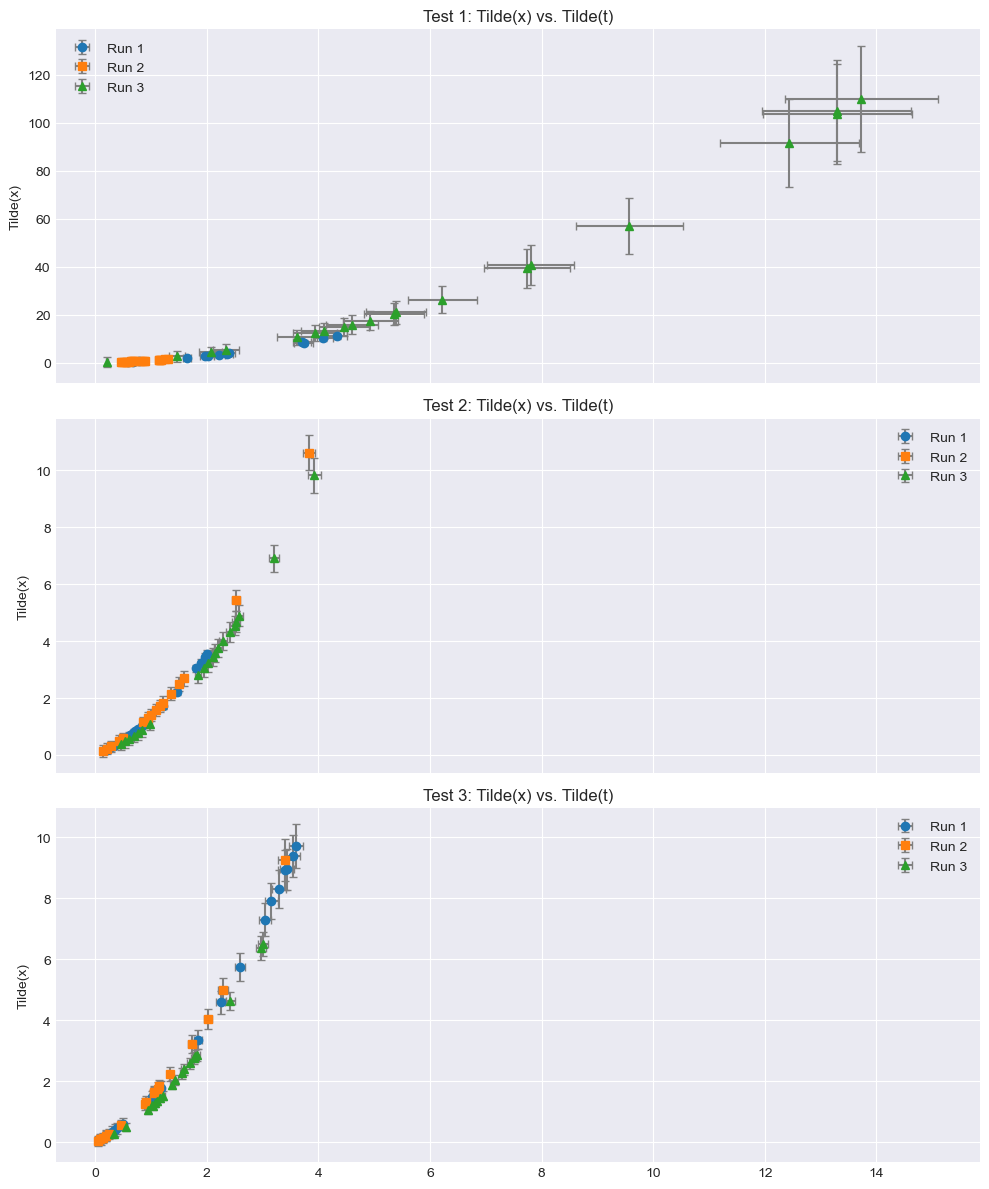

In [70]:

# Group all tilde_x and tilde_t into lists for looping
tests_tilde_x = [
    [test1_run1_tilde_x, test1_run2_tilde_x, test1_run3_tilde_x],
    [test2_run1_tilde_x, test2_run2_tilde_x, test2_run3_tilde_x],
    [test3_run1_tilde_x, test3_run2_tilde_x, test3_run3_tilde_x],
]

tests_tilde_t = [
    [test1_run1_tilde_t, test1_run2_tilde_t, test1_run3_tilde_t],
    [test2_run1_tilde_t, test2_run2_tilde_t, test2_run3_tilde_t],
    [test3_run1_tilde_t, test3_run2_tilde_t, test3_run3_tilde_t],
]

colors = ['tab:blue', 'tab:orange', 'tab:green']
markers = ['o', 's', '^']
test_labels = ['Test 1', 'Test 2', 'Test 3']

# Set up figure
plt.style.use('seaborn-v0_8-darkgrid')
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

for i, ax in enumerate(axs):
    for j in range(3):  # 3 runs per test
        t_tilde = tests_tilde_t[i][j]
        x_tilde = tests_tilde_x[i][j]
        ax.errorbar(
            [val.nominal_value for val in t_tilde], # x values
            [val.nominal_value for val in x_tilde], # y values
            xerr=[val.std_dev for val in t_tilde],
            yerr=[val.std_dev for val in x_tilde],
            fmt=markers[j],
            color=colors[j],
            capsize=3,
            ecolor='gray',
            label=f'Run {j+1}'
        )
    ax.set_ylabel('Tilde(x)')
    ax.set_title(f'{test_labels[i]}: Tilde(x) vs. Tilde(t)')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


# Regresion analysis

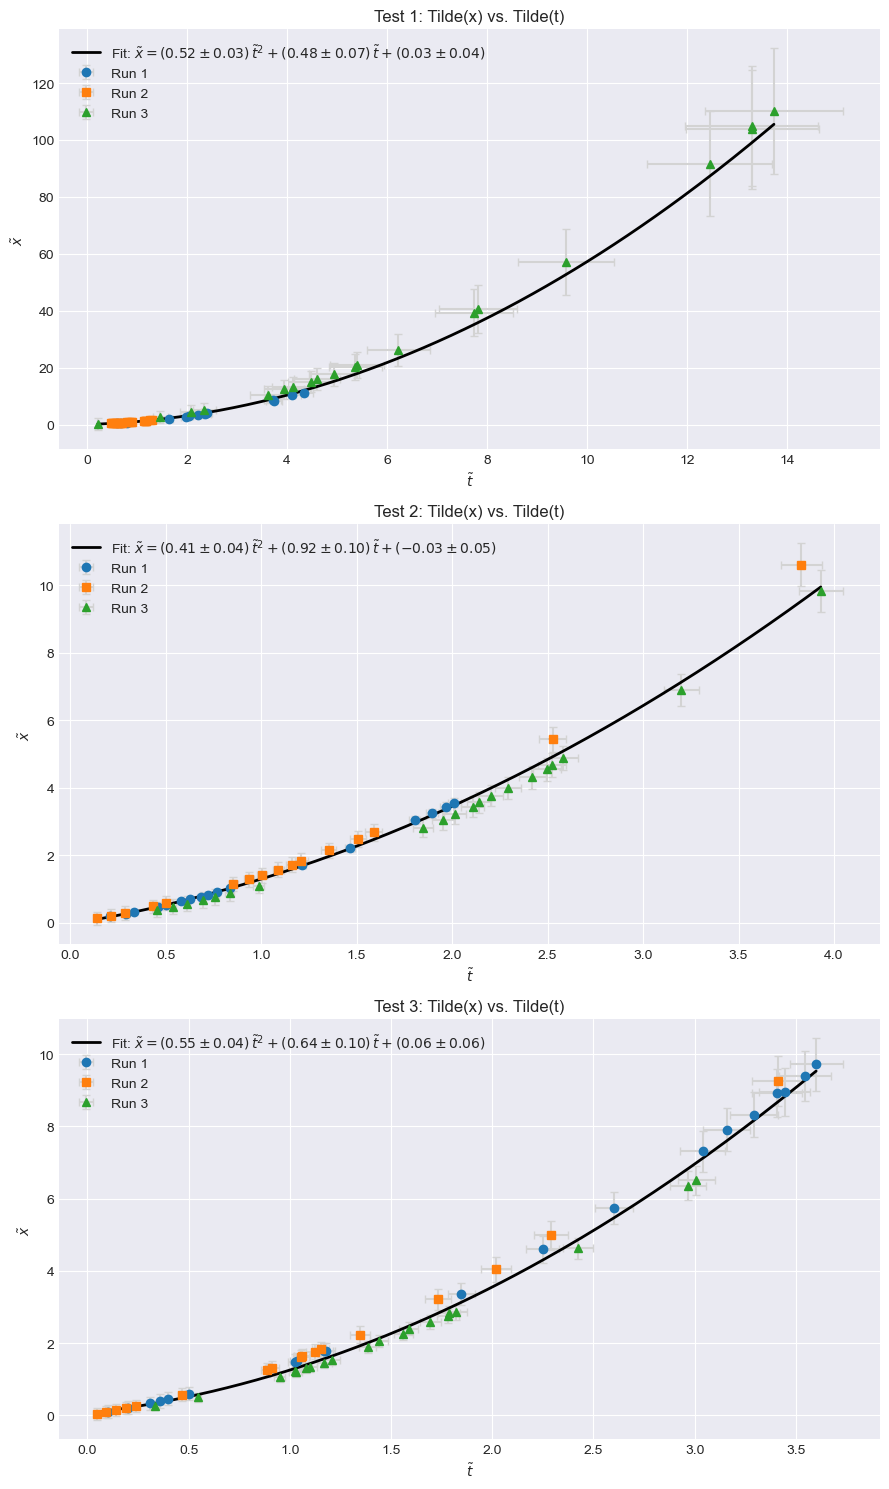

In [71]:
# --- Quadratic model ---
def quadratic_accel_model(t, A, B, C):
    """
    Quadratic model for dimensionless motion:
    tilde{x}(tilde{t}) = A * (tilde{t})^2 + B * (tilde{t}) + C
    """
    return A * t**2 + B * t + C

# --- Linear model ---
def linear_accel_model(t, A, B):
    """
    Linear model for dimensionless motion:
    tilde{x}(tilde{t}) = A * (tilde{t}) + B
    """
    return A * t + B

def plot_test_runs(ax, test_label, runs):
    """
    Plots 3 runs for a single test on the given Axes (ax).
    Each run has:
        (tilde_t, tilde_x) = dimensionless time & displacement arrays with uncertainties.

    1) Plots each run with error bars (different colors/markers).
    2) Concatenates all runs for a combined quadratic fit.
    3) Overlays the best-fit curve on the same subplot.
    4) Labels the subplot with 'test_label'.
    """

    # Some distinct colors/markers for the 3 runs
    colors = ["tab:blue", "tab:orange", "tab:green"]
    markers = ["o", "s", "^"]

    # --- 1. Plot each run individually ---
    for i, (tilde_t, tilde_x) in enumerate(runs):
        x_vals = np.array([val.nominal_value for val in tilde_t])
        y_vals = np.array([val.nominal_value for val in tilde_x])
        x_errs = np.array([val.std_dev for val in tilde_t])
        y_errs = np.array([val.std_dev for val in tilde_x])

        ax.errorbar(
            x_vals, y_vals,
            xerr=x_errs, yerr=y_errs,
            fmt=markers[i], color=colors[i], ecolor="lightgray", capsize=3,
            label=f"Run {i+1}"
        )

    # --- 2. Combine all runs to fit them together ---
    all_tilde_t = np.concatenate([r[0] for r in runs])
    all_tilde_x = np.concatenate([r[1] for r in runs])

    # Extract nominal values and errors
    X_vals = np.array([val.nominal_value for val in all_tilde_t])
    Y_vals = np.array([val.nominal_value for val in all_tilde_x])
    X_errs = np.array([val.std_dev for val in all_tilde_t])
    Y_errs = np.array([val.std_dev for val in all_tilde_x])

    # --- 3. Perform the quadratic fit ---
    params, cov = curve_fit(
        quadratic_accel_model,
        X_vals, Y_vals,
        sigma=Y_errs, absolute_sigma=True
    )
    A, B, C = params
    A_err, B_err, C_err = np.sqrt(np.diag(cov))

    # Create smooth line for the fit
    t_min, t_max = np.min(X_vals), np.max(X_vals)
    t_fit = np.linspace(t_min, t_max, 200)
    x_fit = quadratic_accel_model(t_fit, A, B, C)

    # --- 4. Plot the best-fit curve ---
    ax.plot(
        t_fit, x_fit,
        color="black", linewidth=2,
        label=(
            r"Fit: $\tilde{x} = (%.2f \pm %.2f)\,\tilde{t}^2 + (%.2f \pm %.2f)\,\tilde{t} + (%.2f \pm %.2f)$"
            % (A, A_err, B, B_err, C, C_err)
        )
    )

    # --- Final subplot formatting ---
    ax.set_title(f"{test_label}: Tilde(x) vs. Tilde(t)")
    ax.set_xlabel(r"$\tilde{t}$")
    ax.set_ylabel(r"$\tilde{x}$")
    ax.grid(True)
    ax.legend()

# --------------------------
# Example Usage
# --------------------------
# Assuming you have these variables already:
#   test1_run1_tilde_t, test1_run1_tilde_x
#   test1_run2_tilde_t, test1_run2_tilde_x
#   test1_run3_tilde_t, test1_run3_tilde_x
#   ... and similarly for test2, test3

plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(3, 1, figsize=(9, 15), sharex=False)

# Plot Test 1 (3 runs)
plot_test_runs(
    ax=axes[0],
    test_label="Test 1",
    runs=[
        (test1_run1_tilde_t, test1_run1_tilde_x),
        (test1_run2_tilde_t, test1_run2_tilde_x),
        (test1_run3_tilde_t, test1_run3_tilde_x)
    ]
)

# Plot Test 2 (3 runs)
plot_test_runs(
    ax=axes[1],
    test_label="Test 2",
    runs=[
        (test2_run1_tilde_t, test2_run1_tilde_x),
        (test2_run2_tilde_t, test2_run2_tilde_x),
        (test2_run3_tilde_t, test2_run3_tilde_x)
    ]
)

# Plot Test 3 (3 runs)
plot_test_runs(
    ax=axes[2],
    test_label="Test 3",
    runs=[
        (test3_run1_tilde_t, test3_run1_tilde_x),
        (test3_run2_tilde_t, test3_run2_tilde_x),
        (test3_run3_tilde_t, test3_run3_tilde_x)
    ]
)

plt.tight_layout()
plt.show()


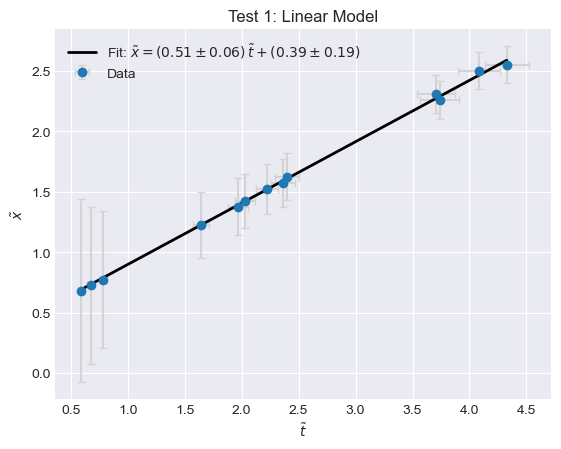

In [72]:
# Plot linear

x_vals = np.array([val.nominal_value for val in test1_run1_linear_x])
y_vals = np.array([val.nominal_value for val in test1_run1_linear_y])
x_errs = np.array([val.std_dev for val in test1_run1_linear_x])
y_errs = np.array([val.std_dev for val in test1_run1_linear_y])

params, cov = curve_fit(
    linear_accel_model,
    x_vals, y_vals,
    sigma=y_errs, absolute_sigma=True
)

A, B = params
A_err, B_err = np.sqrt(np.diag(cov))

# Create smooth line for the fit
x_min, x_max = np.min(x_vals), np.max(x_vals)
x_fit = np.linspace(x_min, x_max, 200)
y_fit = linear_accel_model(x_fit, A, B)

# --- Plot the best-fit curve ---
plt.errorbar(
    x_vals, y_vals,
    xerr=x_errs, yerr=y_errs,
    fmt='o', color='tab:blue', ecolor="lightgray", capsize=3,
    label="Data"
)
plt.plot(
    x_fit, y_fit,
    color="black", linewidth=2,
    label=(
        r"Fit: $\tilde{x} = (%.2f \pm %.2f)\,\tilde{t} + (%.2f \pm %.2f)$"
        % (A, A_err, B, B_err)
    )
)

plt.title("Test 1: Linear Model")
plt.xlabel(r"$\tilde{t}$")
plt.ylabel(r"$\tilde{x}$")
plt.grid(True)
plt.legend()
plt.show()
